Using the CIFAR10 data provided below, create an alogrithm that takes in a gray scale image and coverts it to a color image.

Note for this problem we will define the grayscale image as the average of the three color channels.

In [2]:
from torchvision.datasets import CIFAR10

In [3]:
# imports
import numpy as np
import matplotlib.pyplot as plt

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision.io import read_image
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torchvision import models,transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Compose, ToTensor, Lambda

%matplotlib inline

'\nfrom skimage.color import rgb2lab, lab2rgb\nfrom torchvision.datasets import MNIST\nfrom torch.utils.data import data\n'

Loading CIFAR10 dataset. This holds 10 classes of 32x32 colour images (3 channels)

In [4]:
train_data = CIFAR10(root='./datasets', train=True, download=True, transform=transforms.ToTensor())
test_data = CIFAR10(root='./datasets', train=True, download=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_data,batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data,batch_size=64, shuffle=False, pin_memory=True)


100%|██████████| 170498071/170498071 [00:05<00:00, 28832520.06it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets


**Visualizing CIFAR10 data**

To grasp the task

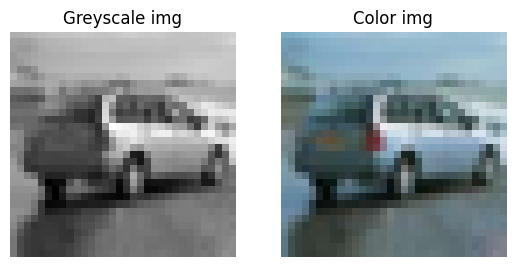

In [5]:
# Visualizing some sample images

figure = plt.figure()

cols, rows = 2, 1
sample_idx = torch.randint(len(train_data), size=(1,)).item()

img, label = train_data[sample_idx]
img_gs = img.mean(dim=0)     # greyscale as avg. over channels (i.e. dim-0)
figure.add_subplot(rows, cols, 1)
plt.title('Greyscale img')
plt.axis("off")
plt.imshow(img_gs.squeeze(), cmap = 'gray')
figure.add_subplot(rows, cols, 2)
plt.title('Color img')
plt.axis("off")
plt.imshow(img.squeeze().permute(1,2,0))
plt.show()


Task is to be able via a *generative method* to input a greyscale image and sample a color one.

In [6]:
# check if gpu is available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

We choose to solve this problem using **convolutional U-Net**.
The principle behind resemples autoencoders network as they consist of an *encoding* network that compresses input data into a lower-dimensional feature space. It then reconstructs input space through a *decoder* network from the feature representation.

The network architecture is as follows:

- Encoding: Network takes 1 channel input. I.e. the greyscale 32x32 image and maps it ti a lower-dimensional latent space representation. We downsample data in the encoder via convolutional layers. The downsampling process reduces the spatial dimensions but increases the depth of the feature maps, allowing the network to capture higher-level features.

- Decoding: Transposed convolutional layers to upsample layers combined with concatenation. The decoder upsamples the feature maps, gradually increasing the spatial dimensions and reducing the depth. Concatenation is used to combine the feature maps from the encoder stage with the upsampled feature maps to retain fine-grained spatial information.



In [54]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # encoder layers
        self.en1 = nn.Conv2d(1, 64, 3,stride=1,padding=1)
        self.ebn1 = nn.BatchNorm2d(64)
        self.en2 = nn.Conv2d(64, 64, 3, stride=2,padding=1)
        self.ebn2 = nn.BatchNorm2d(64)
        self.en3 = nn.Conv2d(64, 128, 3,stride=2,padding=1)
        self.ebn3 = nn.BatchNorm2d(128)
        self.en4 = nn.Conv2d(128, 256, 3,stride=2,padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # decoder layers
        self.t_conv1 = nn.ConvTranspose2d(256, 128, 3, stride=2,padding=1,output_padding=1)
        self.t_conv2 = nn.ConvTranspose2d(256, 64, 3, stride=2,padding=1,output_padding=1)
        self.t_conv3 = nn.ConvTranspose2d(128, 128, 3, stride=2,padding=1,output_padding=1)
        self.t_conv4 = nn.ConvTranspose2d(192, 15, 3, stride=1,padding=1)
        self.dropout = nn.Dropout(0.2)
        self.converge = nn.Conv2d(16,3,3,stride=1,padding=1)


    def forward(self, x):
        # encoding
        x1 = F.relu(self.en1(x))
        x1 = self.ebn1(x1)
        x2 = F.relu(self.en2(x1))
        x2 = self.ebn2(x2)
        x3 = F.relu(self.en3(x2))
        x3 = self.ebn3(x3)
        x4 = F.relu(self.en4(x3))

        # decoding
        xd = F.relu(self.t_conv1(x4))
        xd = torch.cat((xd, x3), dim=1)
        xd = self.dropout(xd)
        xd = F.relu(self.t_conv2(xd))
        xd = torch.cat((xd, x2), dim=1)
        xd = self.dropout(xd)
        xd = F.relu(self.t_conv3(xd))
        xd = torch.cat((xd, x1), dim=1)
        xd = self.dropout(xd)
        xd = F.relu(self.t_conv4(xd))
        xd = torch.cat((xd, x), dim=1)

        x_out = F.relu(self.converge(xd))
        return x_out




In summary the network consists of the following layers and connections:

In [55]:
# instantize our model
model = ConvAutoencoder()
model = model.to(device)
summary(model,input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 16, 16]          36,928
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5            [-1, 128, 8, 8]          73,856
       BatchNorm2d-6            [-1, 128, 8, 8]             256
            Conv2d-7            [-1, 256, 4, 4]         295,168
   ConvTranspose2d-8            [-1, 128, 8, 8]         295,040
           Dropout-9            [-1, 256, 8, 8]               0
  ConvTranspose2d-10           [-1, 64, 16, 16]         147,520
          Dropout-11          [-1, 128, 16, 16]               0
  ConvTranspose2d-12          [-1, 128, 32, 32]         147,584
          Dropout-13          [-1, 192, 32, 32]               0
  ConvTranspose2d-14           [-1, 15,

# Training
We specify training parameters and the loss function as MSE between the predicted color image and the label.
We choose the ADAM optimiser since this seems best practice.
We report training and test loss scores for each epoch of training to measure how training is going and avoid overfitting.

In [56]:
# Training params
EPOCHS = 20
LEARNING_RATE = 1e-4
BATCH_SIZE = 64

# specify loss function
def get_loss(X, Xhat):
  recon_loss = F.mse_loss(X,Xhat)
  return recon_loss

# ADAM optimizer
opt = optim.Adam(model.parameters(), lr = LEARNING_RATE)

# Start training
train_loss_epoch = []
test_loss_epoch = []

for i in range(EPOCHS):
  total_loss = 0
  print('Epoch: {}'.format(i))

  for j,batch in tqdm(enumerate(train_loader)): # parsing training
    X = batch[0].to(device)
    # we input a greyscale image (mean over channels) to out network
    X_gs = X.mean(1).reshape(-1, 1, 32, 32)
    # parse to model
    Xhat = model(X_gs)
    # note we predict Xhat, i.e. a color image which we compare to full color image X
    loss = F.mse_loss(Xhat, X)
    # for each mini-batch we set gradients to zero
    opt.zero_grad()
    # and performs backwards prop
    loss.backward()
    opt.step()

    # accumulate losses from batch
    total_loss+=loss.item()

  print("Train Loss: {:.3f}.. ".format(total_loss))
  train_loss_epoch.append(total_loss)

  test_loss = 0
  # turn off gradients while testing, saves memory and computations
  with torch.no_grad():
      model.eval()
      for j,batch in tqdm(enumerate(test_loader)):
          X = batch[0].to(device)
          X_gs = X.mean(1).reshape(-1, 1, 32, 32)
          Xhat = model(X_gs)
          loss = F.mse_loss(Xhat, X)
          test_loss += loss.item()

  model.train()
  test_loss = test_loss
  print("Test Loss: {:.3f}.. ".format(test_loss))
  test_loss_epoch.append(test_loss)


Epoch: 0


782it [00:30, 25.44it/s]


Train Loss: 21.746.. 


782it [00:17, 44.19it/s]


Test Loss: 5.926.. 
Epoch: 1


782it [00:30, 25.33it/s]


Train Loss: 7.506.. 


782it [00:17, 44.28it/s]


Test Loss: 5.306.. 
Epoch: 2


782it [00:29, 26.47it/s]


Train Loss: 5.833.. 


782it [00:17, 44.02it/s]


Test Loss: 4.675.. 
Epoch: 3


782it [00:29, 26.46it/s]


Train Loss: 4.978.. 


782it [00:17, 44.46it/s]


Test Loss: 4.381.. 
Epoch: 4


782it [00:29, 26.43it/s]


Train Loss: 4.557.. 


782it [00:17, 44.23it/s]


Test Loss: 3.947.. 
Epoch: 5


782it [00:29, 26.22it/s]


Train Loss: 4.305.. 


782it [00:17, 45.17it/s]


Test Loss: 4.208.. 
Epoch: 6


782it [00:29, 26.18it/s]


Train Loss: 4.164.. 


782it [00:17, 45.24it/s]


Test Loss: 4.096.. 
Epoch: 7


782it [00:29, 26.20it/s]


Train Loss: 4.049.. 


782it [00:17, 43.71it/s]


Test Loss: 3.876.. 
Epoch: 8


782it [00:29, 26.35it/s]


Train Loss: 3.926.. 


782it [00:17, 45.17it/s]


Test Loss: 3.802.. 
Epoch: 9


782it [00:29, 26.40it/s]


Train Loss: 3.846.. 


782it [00:17, 44.09it/s]


Test Loss: 3.609.. 
Epoch: 10


782it [00:29, 26.48it/s]


Train Loss: 3.761.. 


782it [00:17, 44.25it/s]


Test Loss: 3.646.. 
Epoch: 11


782it [00:31, 24.65it/s]


Train Loss: 3.685.. 


782it [00:18, 43.31it/s]


Test Loss: 3.556.. 
Epoch: 12


782it [00:29, 26.46it/s]


Train Loss: 3.603.. 


782it [00:17, 43.99it/s]


Test Loss: 3.414.. 
Epoch: 13


782it [00:29, 26.42it/s]


Train Loss: 3.521.. 


782it [00:17, 44.23it/s]


Test Loss: 3.334.. 
Epoch: 14


782it [00:29, 26.63it/s]


Train Loss: 3.431.. 


782it [00:18, 43.01it/s]


Test Loss: 3.270.. 
Epoch: 15


782it [00:29, 26.38it/s]


Train Loss: 3.355.. 


782it [00:16, 46.01it/s]


Test Loss: 3.174.. 
Epoch: 16


782it [00:29, 26.42it/s]


Train Loss: 3.276.. 


782it [00:17, 45.23it/s]


Test Loss: 3.057.. 
Epoch: 17


782it [00:29, 26.08it/s]


Train Loss: 3.176.. 


782it [00:19, 40.63it/s]


Test Loss: 2.912.. 
Epoch: 18


782it [00:30, 25.46it/s]


Train Loss: 3.102.. 


782it [00:19, 41.16it/s]


Test Loss: 2.859.. 
Epoch: 19


782it [00:30, 25.99it/s]


Train Loss: 3.015.. 


782it [00:18, 42.82it/s]

Test Loss: 2.776.. 


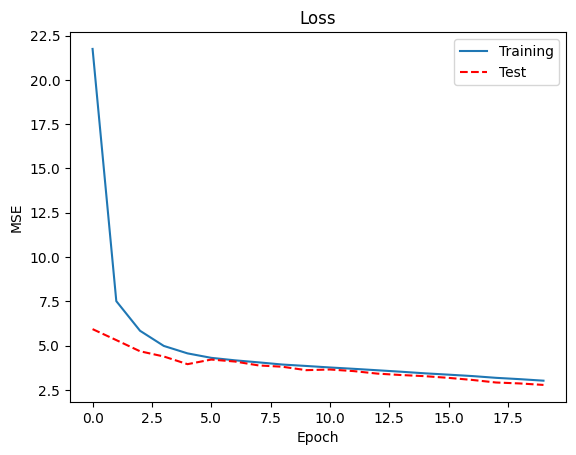

In [57]:
# visualisi loss scores
plt.title('Loss')
plt.plot(train_loss_epoch, label = 'Training')
plt.plot(test_loss_epoch, '--r', label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

Visualizing colorization ability on training samples

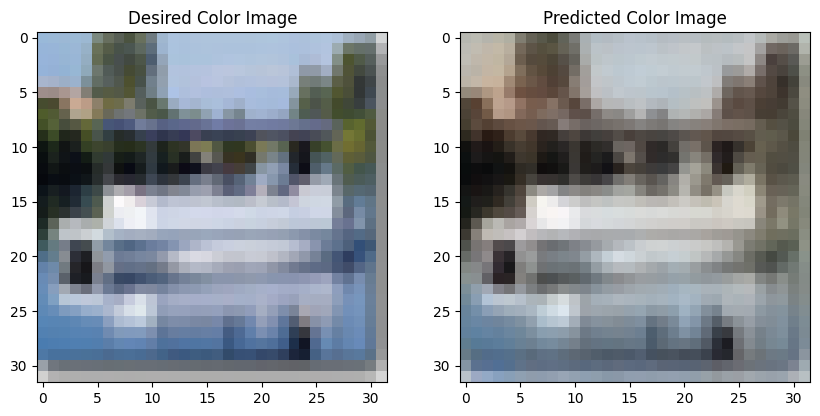

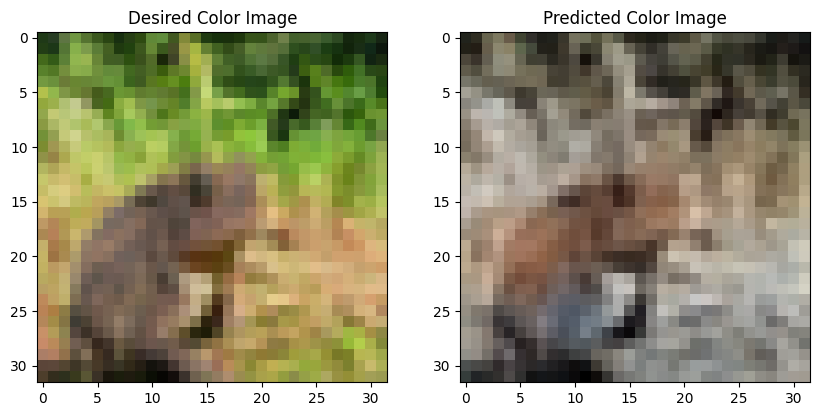

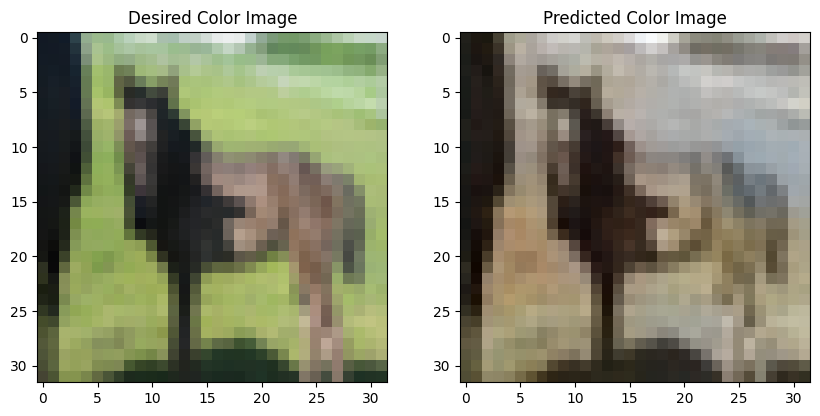

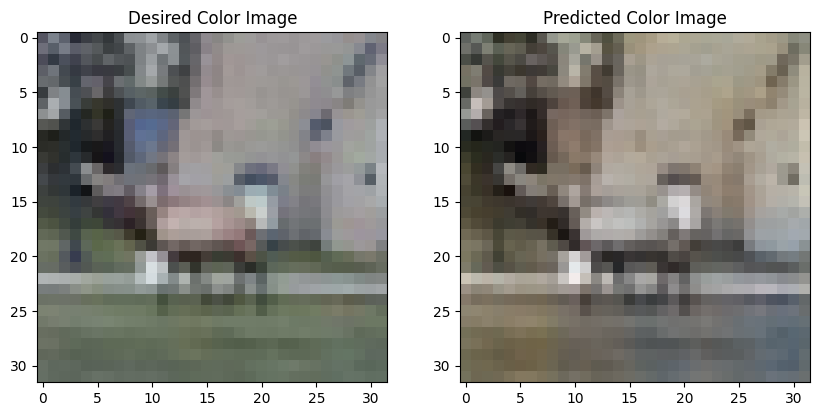

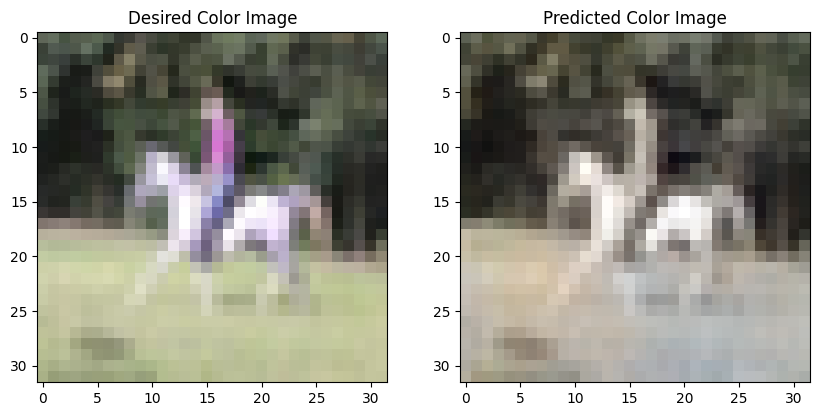

In [58]:
# training data
i=0
while i<5:
    test_img,test_label = next(iter(train_loader))

    # taking mean over channels to obtain greyscale image
    test_img_gs = test_img[0].cuda().mean(0).reshape(-1, 1, 32, 32)

    # predicts from model by evaluating through feed
    pred = model.forward(test_img_gs)

    fig = plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(test_img[0].squeeze().permute(1,2,0))
    plt.title('Desired Color Image')
    plt.subplot(222)
    plt.imshow(pred.cpu().view(3,32,32).permute(1,2,0).detach().numpy())
    plt.title('Predicted Color Image')

    plt.show()
    i+=1


Visulizing on test data

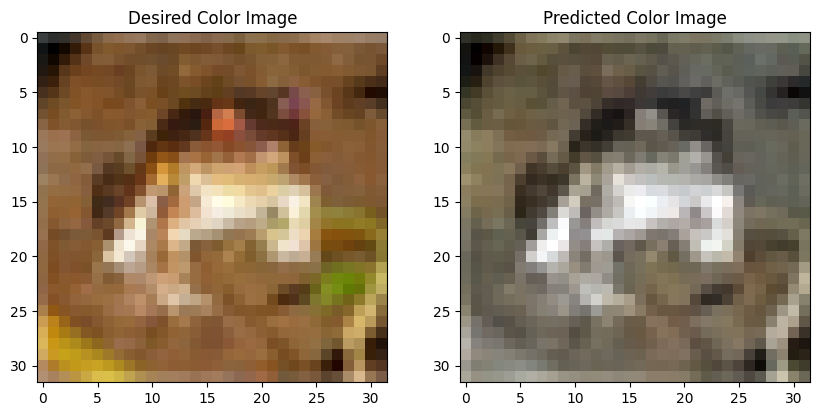

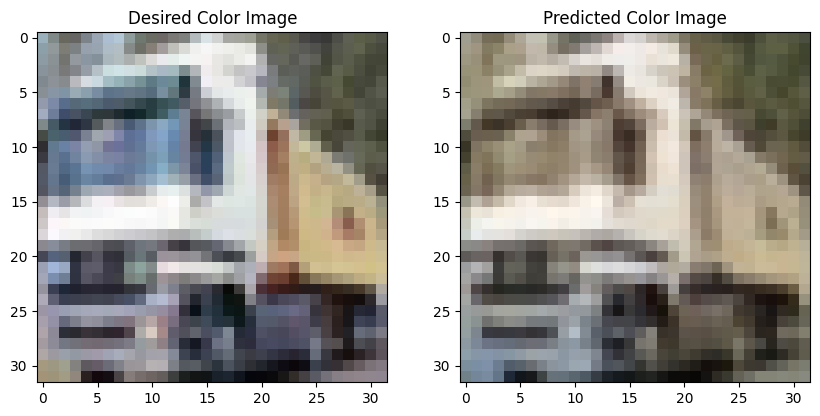

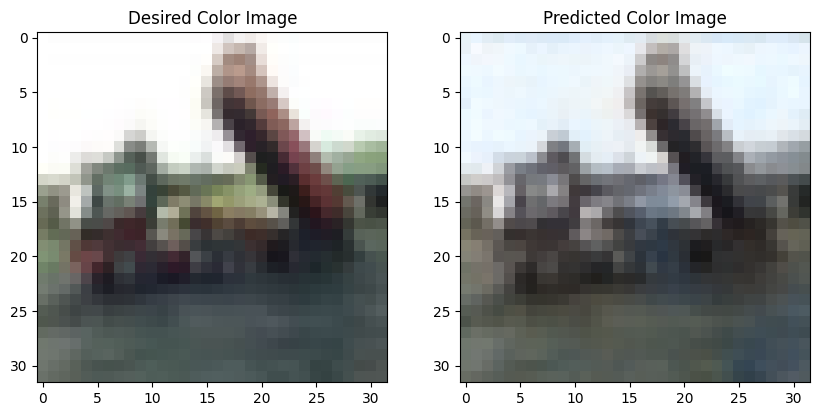

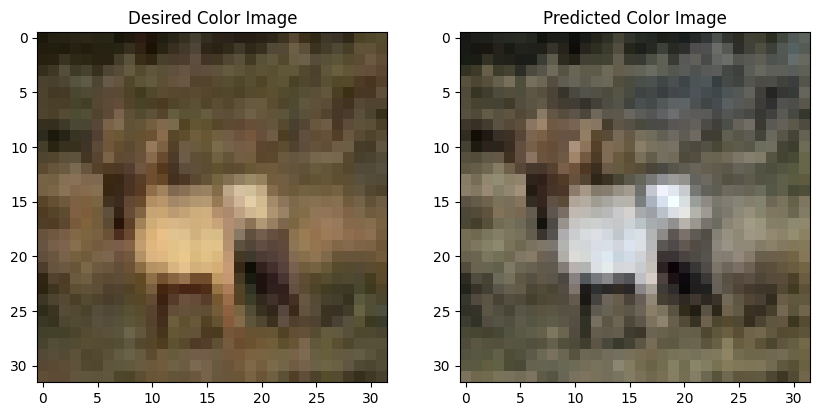

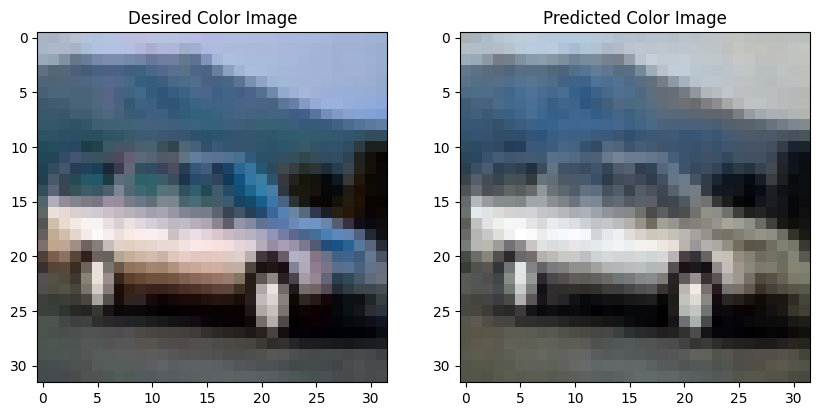

In [59]:
# test data
i=0
while i<5:
    test_img,test_label = next(iter(test_loader))

    # taking mean over channels to obtain greyscale image
    test_img_gs = test_img[i].cuda().mean(0).reshape(-1, 1, 32, 32)

    # predicts from model by evaluating through feed
    pred = model.forward(test_img_gs)

    fig = plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(test_img[i].squeeze().permute(1,2,0))
    plt.title('Desired Color Image')
    plt.subplot(222)
    plt.imshow(pred.cpu().view(3,32,32).permute(1,2,0).detach().numpy())
    plt.title('Predicted Color Image')

    plt.show()
    i+=1